In [33]:
# !pip install pytorchvideo transformers evaluate -q
# !pip install accelerate -U
# !pip install torchvision==0.16.0
# !pip install pytorchvideo
# !pip install ipywidgets


In [34]:
import evaluate
import pytorchvideo.data
import pathlib
import os
import os
import torch
import random
import pathlib
import shutil
from torchvision.transforms import Compose, Lambda, RandomCrop, RandomHorizontalFlip, Resize
from pytorchvideo.transforms import UniformTemporalSubsample, Normalize, RandomShortSideScale, ApplyTransformToKey
from transformers import TrainingArguments, Trainer
from datasets import load_metric
import torch
import os
import pathlib
import imageio
import numpy as np
from IPython.display import Image
from transformers import TrainingArguments, Trainer



In [35]:
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

In [36]:
# Define the root path
dataset_root_path = 'data-split'
dataset_root_path = pathlib.Path(dataset_root_path)

# Get the folder names (surf classes)
surf_classes = [item.name for item in dataset_root_path.glob("*") if item.is_dir()]

# List to store all mp4 files
full_dataset = []

# Iterate over surf classes and aggregate mp4 files
for surf_class in surf_classes:
    print(surf_class)
    surf_class_path = dataset_root_path / surf_class
    mp4_files = surf_class_path.glob("**/*.mp4")
    full_dataset.extend(mp4_files)

# Convert to list for easy access if needed
full_dataset = list(full_dataset)

# display(full_dataset)


test
train
val


In [37]:
def split_data(dataset, random_seed=42):
    random.seed(random_seed)
    torch.manual_seed(random_seed)

    train_size = int(0.7 * len(dataset))
    test_size = int(0.2 * len(dataset))
    val_size = len(dataset) - train_size - test_size

    train_dataset, temp_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size], generator=torch.Generator().manual_seed(random_seed))
    val_dataset, test_dataset = torch.utils.data.random_split(temp_dataset, [val_size, test_size], generator=torch.Generator().manual_seed(random_seed))

    return train_dataset, val_dataset, test_dataset

# Define the root path
dataset_root_path = 'data-split'
dataset_root_path = pathlib.Path(dataset_root_path)

# Iterate over surf classes
for surf_class in surf_classes:
    if surf_class not in ['train', 'val', 'test']:
        surf_class_path = dataset_root_path / surf_class
        mp4_files = list(surf_class_path.glob("**/*.mp4"))

        # Create directories for train, val, and test
        for split in ['train', 'val', 'test']:
            os.makedirs(os.path.join('data-split', split, surf_class), exist_ok=True)

        # Call the function to split the data
        train_dataset, val_dataset, test_dataset = split_data(mp4_files)

        # Move files to respective directories
        for dataset, split in zip([train_dataset, val_dataset, test_dataset], ['train', 'val', 'test']):
            for file_path in dataset:
                shutil.move(file_path, os.path.join('data-split', split, surf_class, os.path.basename(file_path)))

for item in dataset_root_path.iterdir():
    if item.is_dir() and item.name not in ['train', 'val', 'test']:
        shutil.rmtree(item)

In [38]:
dataset_root_path = 'data-split'
dataset_root_path = pathlib.Path(dataset_root_path)
all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.mp4"))
    + list(dataset_root_path.glob("val/*/*.mp4"))
    + list(dataset_root_path.glob("test/*/*.mp4"))
)
class_labels = sorted({str(path).split("\\")[2] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}
print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['360', 'cutback-frontside', 'roller', 'take-off'].


In [39]:
video_count_train = len(list(dataset_root_path.glob("train/*/*.mp4")))
video_count_val = len(list(dataset_root_path.glob("val/*/*.mp4")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.mp4")))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")


Total videos: 1062


In [40]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification,VideoMAEConfig

model_ckpt = "MCG-NJU/videomae-base"  # pre-trained model from which to fine-tune
batch_size = 4  # batch size for training and evaluation

image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)



c:\Users\antoi\Documents\Work_Learn\JEDHA\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
# Define Evaluation Metric
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions.argmax(axis=1)
    references = eval_pred.label_ids
    return metric.compute(predictions=predictions, references=references)

# Define Collate Function
def collate_fn(examples):
    pixel_values = torch.stack([example["video"].permute(1, 0, 2, 3) for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


c:\Users\antoi\Documents\Work_Learn\JEDHA\.venv\Lib\site-packages\datasets\load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [42]:
mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 16
# sample_rate = 32
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps


# Training dataset transfor mations.
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    # RandomShortSideScale(min_size=256, max_size=320),
                    # RandomCrop(resize_to),
                    # RandomHorizontalFlip(p=0.5),
                    Resize((224, 224)),  # Resize images to 224x224

                ]
            ),
        ),
    ]
)

# Training dataset.
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

# Validation and evaluation datasets' transformations.
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    # Resize(resize_to),
                    Resize((224, 224)),  # Resize images to 224x224

                ]
            ),
        ),
    ]
)

# Validation and evaluation datasets.
val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [60]:
tot = train_dataset.num_videos + val_dataset.num_videos + test_dataset.num_videos
train = train_dataset.num_videos/tot*100
val =val_dataset.num_videos/tot*100
test =test_dataset.num_videos/tot*100

print(f'tot:{tot}')
print(f'train: {train:.2f}%')
print(f'test: {test:.2f}%')
print(f'val: {val:.2f}%')


tot:1062
train: 69.77%
test: 19.87%
val: 10.36%


In [45]:
def investigate_video(sample_video):
    """Utility to investigate the keys present in a single video sample."""
    for k in sample_video:
        # print(k)
        if k == "video":
            # print(k, sample_video["video"].shape)
            continue
        else:
            # print(k, sample_video[k])
            continue

    print(f"Video label: {id2label[sample_video[k]]}\n")

In [46]:
def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 4}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

In [47]:
sample_video = next(iter(train_dataset))
sample_video.keys()
sample_video['video_name']

c:\Users\antoi\Documents\Work_Learn\JEDHA\.venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


'Séquence_imbriquée_280.mp4'

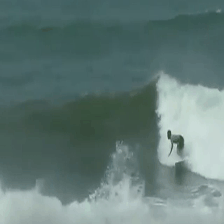

In [48]:
video_tensor = sample_video
video_tensor = sample_video["video"]
display_gif(video_tensor)

In [49]:
model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-2"
num_epochs = 3
batch_size = 4


args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    # push_to_hub=True,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

In [50]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions."""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [51]:
def collate_fn(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [52]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

max_steps is given, it will override any value given in num_train_epochs


In [53]:
# Evaluate the model
active = False
if active:
    eval_results = trainer.evaluate(eval_dataset=val_dataset)
    eval_results
    trainer.evaluate(train_dataset)
    trainer.evaluate(test_dataset)
    trainer.evaluate(val_dataset)
    val_results = trainer.evaluate(eval_dataset=val_dataset)
    val_loss = val_results['eval_loss']

    # Calculate the ratio
    # loss_ratio = val_loss / train_loss

    # Print the ratio
    # print("Validation Loss / Training Loss Ratio:", loss_ratio)

In [54]:
trained_model = VideoMAEForVideoClassification.from_pretrained(new_model_name)

In [55]:
def run_inference(model, video):
    """Utility to run inference given a model and test video.

    The video is assumed to be preprocessed already.
    """
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video["video"].permute(1, 0, 2, 3)

    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [69]:
sample_test_video = next(iter(test_dataset))
investigate_video(sample_test_video)
logits = run_inference(trained_model, sample_test_video)


Video label: roller



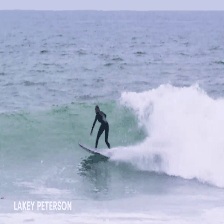

In [ ]:
display_gif(sample_test_video["video"])


In [ ]:
print(logits)
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])


tensor([[-1.7930,  3.8740,  0.6336, -3.0162]])
Predicted class: cutback-frontside


In [ ]:
print(model.config.id2label)

{0: '360', 1: 'cutback-frontside', 2: 'roller', 3: 'take-off'}
